In [26]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

"""
A transformator class which can be fitted to an online signature and used to transform that signature into 
a list of global signature features
"""

class FeatureAnalyzer(BaseEstimator, TransformerMixin):
    """data shape:
        84 <--number of points, first line
        2933 5678 31275775 0 1550 710 439  <-- data point [x,y,times stamp, pen down/up , azimuth, altitude, pressure]
        2933 5678 31275785 1 1480 770 420
        3001 5851 31275795 1 1350 830 433
        .
        .
        .
    """

    def __init__(self, log_progress=False):
        self.log_progress = log_progress

    def fit(self, data):
        features = ["x", "y", "t", "state", "azimuth", "altitude", "pressure"]

        self.df = pd.DataFrame(data, columns=features)

        self.make_time_labels_distinct()

        self.df["y_d"] = (self.df["y"] - self.df["y"].shift(1)) / (self.df["t"] - self.df["t"].shift(1))
        self.df["x_d"] = (self.df["x"] - self.df["x"].shift(1)) / (self.df["t"] - self.df["t"].shift(1))
        self.df["y_d_d"] = (self.df["y_d"] - self.df["y_d"].shift(1)) / (self.df["t"] - self.df["t"].shift(1))
        self.df["x_d_d"] = (self.df["x_d"] - self.df["x_d"].shift(1)) / (self.df["t"] - self.df["t"].shift(1))
        self.df["y_d_d_d"] = (self.df["y_d_d"] - self.df["y_d_d"].shift(1)) / (self.df["t"] - self.df["t"].shift(1))
        self.df["x_d_d_d"] = (self.df["x_d_d"] - self.df["x_d_d"].shift(1)) / (self.df["t"] - self.df["t"].shift(1))

        return self

    def make_time_labels_distinct(self):
        """
        avoid same timestamps in the data
        """
        same_time_values_as_previous_row = self.df.loc[self.df['t'] == self.df['t'].shift(1)].index.tolist()

        self.df["id"] = self.df.index
        self.df.loc[self.df['id'].isin(same_time_values_as_previous_row), 't'] += 1
        self.df.drop(["id"], axis = 1, inplace=True)

        if len(self.df.loc[self.df['t'] == self.df['t'].shift(1)].index.tolist()) != 0:
            self.make_time_labels_distinct()


    def log_progression(self, feature_id):
        if self.log_progress:
            print("calculating feature: %s", feature_id)

    def transform(self, data):
        """
        :param1: data parameter is not used anymore, the fit function saves the data to self.df which is a pandas Dataframe of the data
        returns: a 20-long list of global features
        """
        values = np.zeros(20)

        self.log_progression(1)
        values[0] = self.calc_duration()
        self.log_progression(2)
        values[1] = self.calc_pen_ups()
        self.log_progression(3)
        values[2] = self.calc_sign_changes_in_col("x") + self.calc_sign_changes_in_col("y")
        self.log_progression(4)
        values[3] = self.calc_avg_jerk()
        self.log_progression(5)
        values[4] = self.calc_std_dev_in_col("y_d_d")
        self.log_progression(6)
        values[5] = self.calc_std_dev_in_col("y_d")
        self.log_progression(7)
        values[6] = self.f7()
        self.log_progression(8)
        values[7] = self.count_local_maxima_in_col("x")
        self.log_progression(9)
        values[8] = self.calc_std_dev_in_col("x_d_d")
        self.log_progression(10)
        values[9] = self.calc_std_dev_in_col("x_d")
        self.log_progression(11)
        values[10] = self.f11()
        self.log_progression(12)
        values[11] = self.count_local_maxima_in_col("y")
        self.log_progression(13)
        values[12] = self.f13()
        self.log_progression(14)
        values[13] = self.f14()
        self.log_progression(15)
        values[14] = self.f15()
        self.log_progression("16 and 18")
        values[15], values[17] = self.f16_and_18()
        self.log_progression("17 and 19")
        values[16], values[18] = self.f17_and_f19()
        self.log_progression(20)
        values[19] = self.f22()

        return values

    def calc_duration(self):
        return self.df["t"].iloc[-1] - self.df["t"].iloc[0]

    def calc_avg_jerk(self):
        self.df["abs_jerk"] = np.sqrt(self.df["x_d_d_d"] * self.df["x_d_d_d"] + self.df["y_d_d_d"] * self.df["y_d_d_d"])
        mean = self.df["abs_jerk"].mean()
        return mean

    def calc_std_dev_in_col(self, col_name):
        return self.df[col_name].std()

    def count_local_maxima_in_col(self, col_name):
        c = 0
        col = self.df[col_name]
        for i in range(1, len(col) - 1):
            if col.iloc[i + 1] < col.iloc[i] > col.iloc[i - 1]:
                c += 1
        if col.iloc[0] > col.iloc[1]:
            c += 1
        if col.iloc[-1] > col.iloc[-2]:
            c += 2
        return c

    def f11(self):  # Jerk rms
        return (self.df["abs_jerk"] ** 2).mean() ** 0.5

    def f13(self):  # t(2nd pen_down) / duration
        pen_downs_found = 0
        for row_idx in range(len(self.df)):
            if self.df["state"].iloc[row_idx] == 0:
                pen_downs_found += 1
            if pen_downs_found == 2:
                return self.df["t"].iloc[row_idx] / self.calc_duration()

        return 1  # just in case

    def f14(self):  # (avg abs(velocity)) / (maximum of Vx)
        return ((self.df["x_d"].iloc[1:] ** 2 + self.df["y_d"].iloc[1:] ** 2) ** 0.5).mean() / self.df["x_d"].iloc[
                                                                                               1:].max()

    def delta(self, col_idx):
        sum_ = 0
        state_idx = 3
        curr_max = self.df.loc[1][col_idx]
        curr_min = self.df.loc[1][col_idx]
        for record in self.df.iterrows():
            if record[1][state_idx] == 0:
                sum_ += curr_max - curr_min
                curr_max = -np.inf
                curr_min = np.inf
            if record[1][col_idx] > curr_max:
                curr_max = record[1][col_idx]
            if record[1][col_idx] < curr_min:
                curr_min = record[1][col_idx]
        
        if sum_== 0:
            sum_= 1
        return sum_

    def f15(self):
        A_min = (self.df['y'].max() - self.df['y'].min()) * (self.df['x'].max() - self.df['x'].min())
        denominator = self.delta(0) * self.delta(1)
        return A_min / denominator

    def f7(self):
        return self.calc_std_dev_in_col('y') / self.delta(1)

    def f16_and_18(self):
        for i in range(len(self.df) - 1, -1, -1):
            if self.df['state'].iloc[i] == 0:
                x_last_penup = self.df['x'].iloc[i]
                y_last_penup = self.df['y'].iloc[i]
                x_max = self.df['x'].max()
                y_min = self.df['y'].min()
                f16 = (x_last_penup - x_max) / self.delta(0)
                f18 = (y_last_penup - y_min) / self.delta(1)
                return f16, f18

    def f17_and_f19(self):
        for i in range(len(self.df)):
            if self.df['state'].iloc[i] == 1:
                x_first_pendown = self.df['x'].iloc[i]
                y_first_pendown = self.df['y'].iloc[i]
                x_max = self.df['x'].max()
                y_min = self.df['y'].min()
                f17 = (x_first_pendown - x_max) / self.delta(0)
                f19 = (y_first_pendown - y_min) / self.delta(1)
                return f17, f19

    def f22(self):
        indices = self.df.index[self.df['state'] == 0].tolist()
        pendown_duration = 0
        for i in indices:
            pendown_duration += self.df['t'].loc[i + 1] - self.df['t'].loc[i]

        return pendown_duration / self.calc_duration()

    def calc_sign_changes_in_col(self, col_name):
        col = self.df[col_name]
        c = 0
        for i in range(1, len(col) - 1):
            if col[i] < col[i + 1] != col[i - 1] < col[i]:
                c += 1
        return c

    def get_feature_list(self):
        return self.analyze()

    def calc_pen_ups(self):
        return len(self.df.index[self.df['state'] == 0].tolist())


In [2]:

def fetch_user_data(user_id):
    #takes a user id and reads it into an array from the folder /SVC2004_Online
    all_signatures = np.zeros(40, object)

    for signature_id in range(1, 41):
        filename = "U" + str(user_id) + "S" + str(signature_id) + ".txt"
        path = os.path.join(os.getcwd(), "SVC2004_Online", filename)

        with open(path) as f:
            lines = (line for line in f)
            sig_data = np.loadtxt(lines, delimiter=' ', skiprows=1)

            all_signatures[signature_id - 1] = sig_data

    return np.array(all_signatures)

In [3]:

def cluster_feature_vectors(number_of_global_features, feature_vectors):
    #clusters feature vectors using Kmeans and returns the clusterer object which stores and clusters 
    clusterer = KMeans(n_clusters=int(number_of_global_features * 0.6))
    clusterer.fit(feature_vectors)

    return clusterer


In [4]:
import numpy as np
from sklearn.cluster import KMeans

from FeatureAnalyzer import FeatureAnalyzer
from model import create_model
import os

number_of_global_features = 20 #that I calculate and use for training

def get_signatures_and_labels(user_id):
    #reads a user ID and returns the data and the labels for supervised learning
    user_signatures = fetch_user_data(user_id)

    labels = np.array([x // 20 for x in range(40)]).astype("float32")  # first 20 valid, second 20 forgery. forgery = 1

    return user_signatures,labels
    

In [5]:
def generate_signature_features(user_signatures):
    #calculates the global features of the signature and returns them in a 20-long array
    analyzer = FeatureAnalyzer()
    signature_features = np.zeros(shape=(len(user_signatures), number_of_global_features))
    for idx, sig in enumerate(user_signatures):
        signature_features[idx] = analyzer.fit_transform(sig)
        
    return signature_features

In [6]:
def generate_feature_vectors(signature_features):
    #creates the feature vectors described in the source research paper
    feature_vectors = signature_features.transpose()
    feature_vectors = np.reshape(feature_vectors, (40, 20))
    
    return feature_vectors

In [8]:
def get_cluster_representatives(clusterer, feature_vectors):
    #calculates cluster representatives based on the Meadian of Medians algorithm which is mentioned and used
    #in the source research paper
    labels = clusterer.labels_
    groups = dict()
    
    for idx, vector in enumerate(feature_vectors):
        label = labels[idx]
        if label not in groups:
            groups[label] = [vector]
        else:
            groups[label].append(vector)
        
    cluster_heads = []
    for group in groups:
        vectors_in_group = groups[group]
        
        vector_medians = []
        for vector in vectors_in_group:
            vector_medians = []
            for idx,feature in enumerate(vector):
                feature_medians = []
                for other_feature in vector:
                    feature_medians.append(abs(feature-other_feature))
                    
                feature_median = np.median(feature_medians)
                feature_medians.append(feature_median)

            vector_median = np.median(feature_medians)
            vector_medians.append(vector_median)
        
        representative = np.median(vector_medians)
        cluster_heads.append(representative)
    
    return cluster_heads
            

In [9]:
def make_clusters_and_representatives(feature_vectors):
    #creates the clusters and returns the cluster representatives of the clusters. The representatives are calculated
    #using the Median of Medians algorithm
    clusterer = cluster_feature_vectors(number_of_global_features, feature_vectors) #12 clusters from 20 vectors
    clusterer.labels_

    representatives = get_cluster_representatives(clusterer,feature_vectors)
    representatives = np.array(representatives)
    
    return representatives

In [10]:
def get_input_vectors(signature_features,representatives):
    #Creates the input vectors to be fed to the neural network. It consists of the global features
    #plus the feature representatives
    input_vectors = np.zeros(shape=(40,32))
    for idx,signature_feature in enumerate(signature_features):
        input_vectors[idx] = np.append(signature_feature,representatives, axis = 0)

    ipnut_vectors = signature_features
    
    return input_vectors

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
def split_and_scale_data(input_vectors,labels,scale=True):
    #data preprocessing. returns 3 splits to be used for training.
    X = input_vectors
    y = labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    if(scale):
        std_scaler = StandardScaler()
        X_train[:,:20] = std_scaler.fit_transform(X_train[:,:20])
        X_valid[:,:20] = std_scaler.transform(X_valid[:,:20])
        X_test[:,:20] = std_scaler.transform(X_test[:,:20])
    
    return (X_train,y_train), (X_valid,y_valid), (X_test,y_test)
    

In [13]:
def reshape_to_input(X_train,X_valid,X_test):
    #reshaping to match the required shape by the first layer in the model
    X_train = np.reshape(X_train,(X_train.shape[0],-1,X_train.shape[1]))
    X_valid = np.reshape(X_valid,(X_valid.shape[0],-1,X_valid.shape[1]))
    X_test = np.reshape(X_test,(X_test.shape[0],-1,X_test.shape[1]))
    
    return X_train,X_valid,X_test
    

In [14]:
def prepare_data_of_user(user_id):
    #reads a user's data and fully prepares if for training
    signatures,labels = get_signatures_and_labels(user_id)

    signature_features = generate_signature_features(signatures)

    feature_vectors = generate_feature_vectors(signature_features)

    representatives = make_clusters_and_representatives(feature_vectors)

    input_vectors = get_input_vectors(signature_features,representatives)

    (X_train,y_train), (X_valid,y_valid), (X_test,y_test) = split_and_scale_data(input_vectors,labels,scale=True)
    X_train, X_valid, X_test = reshape_to_input(X_train, X_valid, X_test)
    
    return (X_train,y_train), (X_valid,y_valid), (X_test,y_test)

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SeparableConv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
#learning rate scheduler for training
def scheduler(epoch,lr):
    return 0.001
    if(epoch < 5000):
        return 0.000005
    else:
        return 0.0000005



#return a model with the recommended architecture and calculated hyperparameters
def create_model(lr):
    model = Sequential()

    model.add(SeparableConv1D(filters=96, kernel_size=7, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(SeparableConv1D(filters=32, kernel_size=5, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(LSTM(96,recurrent_dropout=0.2, return_sequences=True))
    model.add(Flatten())

    model.add(Dense(32, kernel_initializer="random_uniform",bias_initializer="random_uniform",activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))

    model.add(Dense(64, kernel_initializer="random_uniform",bias_initializer="random_uniform",activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.0))

    model.add(Dense(1,activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=lr) ,loss="binary_crossentropy")
    return model


In [18]:
def create_and_train_model(user_id, X_train,y_train, X_valid,y_valid, learning_rate=0.001):
    #trains a model on a user
    #returns the model and the trainig history

    model = create_model(learning_rate)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    early_stopping = EarlyStopping(patience=500, verbose=2,monitor='val_loss', mode='min')
    history = model.fit(X_train,y_train, validation_data=(X_valid,y_valid),epochs = 10000,batch_size=8,verbose = 1,
                       callbacks=[early_stopping])

    
    
    return model,history

In [20]:
import matplotlib.pyplot as plt

plt_rows = 7 #for pyplot subplots
plt_cols = 7 #for pyplot subplots

def evaluate_model(user_id,model,X_test,y_test,history,axs):
    #evaluates the model on the test set, prints the results and adds 
    #the training history to a pyplot subplot
    print("Evaluating predictions for user",user_id)
    preds = model.predict(X_test)
    print("prediction for test:\n",preds)
    print("labels:",y_test)
    
    err = 0
    false_positives = 0
    false_negatives = 0
    positives = 0
    negatives = 0
    for idx,pred in enumerate(model.predict(X_test)):
        
        if y_test[idx] == 1:
            positives+=1
        else:
            negatives+=1
        
        
        if y_test[idx] == 1.0 and pred[0] < 0.5:
            false_negatives += 1
        elif y_test[idx] == 0.0 and pred[0] > 0.5:
            false_positives+=1
        
        
        err+= round(abs(pred[0]-y_test[idx]))
    
    errs.append(err)
    print("Misclassified:",err,"out of",len(preds))
    
    
    user_id -=1 #to 0-39 from 1-40
    
    plt_row = user_id//plt_rows
    plt_col = user_id%plt_cols

    
    axs[plt_row, plt_col].plot(history.history["loss"])
    
    return (false_positives,false_negatives,positives,negatives)
    

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SeparableConv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#creates and returns a model for hyperparameter optimization using keras_tuner
def create_model_hiperopti(hp):
    model = Sequential()

    model.add(SeparableConv1D(filters=hp.Choice(name="conv_1_filter", values=[32,96]), 
                              kernel_size=hp.Choice(name="conv_1_kernel", values=[3,5,7]), 
                              padding="same", 
                              activation="relu",
                              input_shape=(1, 32)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice(name="dropout_1", values=[0.1,0.5,0.7])))

    model.add(SeparableConv1D(filters=hp.Choice(name="conv_2_filter", values=[32,96]), 
                              kernel_size=hp.Choice(name="conv_2_kernel", values=[3,5,7]), 
                              padding="same", 
                              activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice(name="dropout_2", values=[0.2,0.4,0.6])))

    model.add(LSTM(hp.Choice(name="lstm_nodes", values=[64,96]),recurrent_dropout=0.2, return_sequences=True))
    model.add(Flatten())

    model.add(Dense(hp.Choice(name="dense_1_nodes", values=[64,32]), 
                    kernel_initializer="random_uniform",
                    bias_initializer="random_uniform",
                    activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice(name="dropout_3", values=[0.0,0.3,0.6])))

    model.add(Dense(hp.Choice(name="dense_2_nodes", values=[64,32]), 
                    kernel_initializer="random_uniform",
                    bias_initializer="random_uniform",
                    activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice(name="dropout_4", values=[0.0,0.5])))

    model.add(Dense(1,activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=hp.Choice(name="learning_rate", values=[0.001,0.00001])) ,
                                 loss="binary_crossentropy")
    
    return model


In [23]:
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from keras.callbacks import EarlyStopping
#Does a hpyerparameter optimization on the test and validitaion sets given
#Using keras_tuner and randomsearch. returns a model built with the best parameters
def hyperopti(X_train,y_train, X_valid,y_valid):
    tuner = RandomSearch(
        create_model_hiperopti,
        objective='val_loss',
        max_trials=50,
        directory="tuner_runs")

    print(tuner.search_space_summary())
    
    early_stopping = EarlyStopping(patience=500, verbose=2,monitor='val_loss', mode='min')
    

    tuner.search(X_train, y_train,
                 epochs=2000, validation_data=(X_valid,y_valid),
                 callbacks=[early_stopping,keras.callbacks.TensorBoard("tuner_runs/tb_logs")]
                 )

    best_model = tuner.get_best_models(num_models=1)[0]

    params_best = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("best params\n",params_best.get_config()['values'])
    
    return tuner.hypermodel.build(params_best)



In [24]:
#launches a hyperparameter optimization on a user. returns the best model found.
def hyperopti_on_user(id_):
    (X_train,y_train), (X_valid,y_valid), (X_test,y_test) = prepare_data_of_user(id_)
    print(X_valid.shape)
    best_model = hyperopti(X_train,y_train, X_valid,y_valid)
    return best_model

In [ ]:
model = hyperopti_on_user(19)

Trial 22 Complete [00h 00m 58s]
val_loss: 0.0002452078042551875

Best val_loss So Far: 1.2334548955550417e-06
Total elapsed time: 00h 30m 49s

Search: Running Trial #23

Hyperparameter    |Value             |Best Value So Far 
conv_1_filter     |96                |96                
conv_1_kernel     |3                 |7                 
dropout_1         |0.7               |0.1               
conv_2_filter     |32                |32                
conv_2_kernel     |3                 |5                 
dropout_2         |0.6               |0.4               
lstm_nodes        |96                |96                
dense_1_nodes     |64                |32                
dropout_3         |0                 |0.6               
dense_2_nodes     |32                |64                
dropout_4         |0                 |0                 
learning_rate     |0.001             |0.001             

Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 0.6353 - val_loss

Epoch 74/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.1389 - val_loss: 0.6997
Epoch 75/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.2165 - val_loss: 0.6998
Epoch 76/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.1080 - val_loss: 0.6999
Epoch 77/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.1299 - val_loss: 0.6999
Epoch 78/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.1794 - val_loss: 0.7000
Epoch 79/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.3360 - val_loss: 0.6999
Epoch 80/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.1163 - val_loss: 0.7000
Epoch 81/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0931 - val_loss: 0.7000
Epoch 82/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.1722 - val_loss: 0.7000
Epoch 83/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.2133 - val_loss: 0.6999


1/1 [==============================] - 0s 34ms/step - loss: 0.0067 - val_loss: 0.7046
Epoch 237/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0087 - val_loss: 0.7051
Epoch 238/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0042 - val_loss: 0.7052
Epoch 239/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0029 - val_loss: 0.7053
Epoch 240/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0132 - val_loss: 0.7056
Epoch 241/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0025 - val_loss: 0.7061
Epoch 242/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0304 - val_loss: 0.7066
Epoch 243/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0057 - val_loss: 0.7072
Epoch 244/2000
1/1 [==============================] - 0s 79ms/step - loss: 0.0171 - val_loss: 0.7075
Epoch 245/2000
1/1 [==============================] - 0s 40ms/step - loss: 0.0949 - val_loss: 0.7078
Epoch

1/1 [==============================] - 0s 37ms/step - loss: 0.0032 - val_loss: 1.4387
Epoch 399/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0019 - val_loss: 1.4461
Epoch 400/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0190 - val_loss: 1.4533
Epoch 401/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0026 - val_loss: 1.4584
Epoch 402/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0039 - val_loss: 1.4634
Epoch 403/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0030 - val_loss: 1.4677
Epoch 404/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0020 - val_loss: 1.4730
Epoch 405/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0098 - val_loss: 1.4799
Epoch 406/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0028 - val_loss: 1.4871
Epoch 407/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0146 - val_loss: 1.4972
Epoch

1/1 [==============================] - 0s 32ms/step - loss: 0.0011 - val_loss: 2.4411
Epoch 560/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0028 - val_loss: 2.4904
Epoch 561/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0011 - val_loss: 2.5255
Epoch 562/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0011 - val_loss: 2.5566
Epoch 563/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0028 - val_loss: 2.5877
Epoch 564/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0023 - val_loss: 2.6148
Epoch 565/2000
1/1 [==============================] - 0s 36ms/step - loss: 0.0011 - val_loss: 2.6381
Epoch 566/2000
1/1 [==============================] - 0s 35ms/step - loss: 9.8227e-04 - val_loss: 2.6540
Epoch 567/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0025 - val_loss: 2.6764
Epoch 568/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0012 - val_loss: 2.6940
E

Epoch 639/2000
1/1 [==============================] - 0s 86ms/step - loss: 6.5480e-04 - val_loss: 0.0539
Epoch 640/2000
1/1 [==============================] - 0s 86ms/step - loss: 0.0014 - val_loss: 0.0461
Epoch 641/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0029 - val_loss: 0.0823
Epoch 642/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0011 - val_loss: 0.1938
Epoch 643/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0010 - val_loss: 0.3650
Epoch 644/2000
1/1 [==============================] - 0s 36ms/step - loss: 0.0081 - val_loss: 0.5594
Epoch 645/2000
1/1 [==============================] - 0s 37ms/step - loss: 0.0188 - val_loss: 0.7376
Epoch 646/2000
1/1 [==============================] - 0s 37ms/step - loss: 0.0023 - val_loss: 0.8860
Epoch 647/2000
1/1 [==============================] - 0s 36ms/step - loss: 0.0010 - val_loss: 1.0219
Epoch 648/2000
1/1 [==============================] - 0s 35ms/step - loss: 6.3129e-04 -

Epoch 797/2000
1/1 [==============================] - 0s 33ms/step - loss: 6.6094e-04 - val_loss: 0.3700
Epoch 798/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0109 - val_loss: 0.3861
Epoch 799/2000
1/1 [==============================] - 0s 35ms/step - loss: 4.1672e-04 - val_loss: 0.4070
Epoch 800/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0012 - val_loss: 0.4223
Epoch 801/2000
1/1 [==============================] - 0s 59ms/step - loss: 9.7440e-04 - val_loss: 0.4354
Epoch 802/2000
1/1 [==============================] - 0s 53ms/step - loss: 5.7938e-04 - val_loss: 0.4466
Epoch 803/2000
1/1 [==============================] - 0s 38ms/step - loss: 4.6521e-04 - val_loss: 0.4591
Epoch 804/2000
1/1 [==============================] - 0s 38ms/step - loss: 5.3208e-04 - val_loss: 0.4695
Epoch 805/2000
1/1 [==============================] - 0s 34ms/step - loss: 4.2158e-04 - val_loss: 0.4767
Epoch 806/2000
1/1 [==============================] - 0s 36ms/s

Epoch 954/2000
1/1 [==============================] - 0s 35ms/step - loss: 5.9873e-04 - val_loss: 2.3353
Epoch 955/2000
1/1 [==============================] - 0s 34ms/step - loss: 0.0010 - val_loss: 2.3340
Epoch 956/2000
1/1 [==============================] - 0s 36ms/step - loss: 6.2834e-04 - val_loss: 2.3332
Epoch 957/2000
1/1 [==============================] - 0s 33ms/step - loss: 4.3133e-04 - val_loss: 2.3334
Epoch 958/2000
1/1 [==============================] - 0s 33ms/step - loss: 9.1036e-04 - val_loss: 2.3490
Epoch 959/2000
1/1 [==============================] - 0s 34ms/step - loss: 9.1016e-04 - val_loss: 2.3513
Epoch 960/2000
1/1 [==============================] - 0s 33ms/step - loss: 6.9513e-04 - val_loss: 2.3471
Epoch 961/2000
1/1 [==============================] - 0s 35ms/step - loss: 0.0031 - val_loss: 2.3497
Epoch 962/2000
1/1 [==============================] - 0s 32ms/step - loss: 5.2304e-04 - val_loss: 2.3536
Epoch 963/2000
1/1 [==============================] - 0s 35ms/s

1/1 [==============================] - 0s 34ms/step - loss: 2.8424e-04 - val_loss: 3.8271
Epoch 1110/2000
1/1 [==============================] - 0s 35ms/step - loss: 9.0844e-04 - val_loss: 3.8522
Epoch 1111/2000
1/1 [==============================] - 0s 33ms/step - loss: 4.2446e-04 - val_loss: 3.8652
Epoch 1112/2000
1/1 [==============================] - 0s 33ms/step - loss: 4.3805e-04 - val_loss: 3.8808
Epoch 1113/2000
1/1 [==============================] - 0s 34ms/step - loss: 2.5287e-04 - val_loss: 3.8949
Epoch 1114/2000
1/1 [==============================] - 0s 33ms/step - loss: 3.0902e-04 - val_loss: 3.9070
Epoch 1115/2000
1/1 [==============================] - 0s 34ms/step - loss: 2.7648e-04 - val_loss: 3.9171
Epoch 1116/2000
1/1 [==============================] - 0s 34ms/step - loss: 2.6390e-04 - val_loss: 3.9301
Epoch 1117/2000
1/1 [==============================] - 0s 33ms/step - loss: 2.6959e-04 - val_loss: 3.9450
Epoch 1118/2000
1/1 [==============================] - 0s 34ms

1/1 [==============================] - 0s 32ms/step - loss: 2.4484e-04 - val_loss: 0.0248
Epoch 1264/2000
1/1 [==============================] - 0s 32ms/step - loss: 2.8215e-04 - val_loss: 0.0257
Epoch 1265/2000
1/1 [==============================] - 0s 32ms/step - loss: 3.5765e-04 - val_loss: 0.0263
Epoch 1266/2000
1/1 [==============================] - 0s 33ms/step - loss: 7.0867e-04 - val_loss: 0.0272
Epoch 1267/2000
1/1 [==============================] - 0s 32ms/step - loss: 2.1861e-04 - val_loss: 0.0280
Epoch 1268/2000
1/1 [==============================] - 0s 34ms/step - loss: 3.1203e-04 - val_loss: 0.0269
Epoch 1269/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0053 - val_loss: 0.0287
Epoch 1270/2000
1/1 [==============================] - 0s 33ms/step - loss: 2.7153e-04 - val_loss: 0.0306
Epoch 1271/2000
1/1 [==============================] - 0s 33ms/step - loss: 3.1548e-04 - val_loss: 0.0325
Epoch 1272/2000
1/1 [==============================] - 0s 33ms/ste

Epoch 1341/2000
1/1 [==============================] - 0s 32ms/step - loss: 6.5739e-04 - val_loss: 1.0260
Epoch 1342/2000
1/1 [==============================] - 0s 34ms/step - loss: 8.1041e-04 - val_loss: 1.0711
Epoch 1343/2000
1/1 [==============================] - 0s 38ms/step - loss: 2.4119e-04 - val_loss: 1.1198
Epoch 1344/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0019 - val_loss: 1.1353
Epoch 1345/2000
1/1 [==============================] - 0s 33ms/step - loss: 2.2458e-04 - val_loss: 1.1340
Epoch 1346/2000
1/1 [==============================] - 0s 32ms/step - loss: 4.0372e-04 - val_loss: 1.1671
Epoch 1347/2000
1/1 [==============================] - 0s 33ms/step - loss: 1.9013e-04 - val_loss: 1.1650
Epoch 1348/2000
1/1 [==============================] - 0s 33ms/step - loss: 2.2591e-04 - val_loss: 1.1867
Epoch 1349/2000
1/1 [==============================] - 0s 35ms/step - loss: 2.1571e-04 - val_loss: 1.2171
Epoch 1350/2000
1/1 [=============================

1/1 [==============================] - 0s 33ms/step - loss: 1.6653e-04 - val_loss: 0.0019
Epoch 1496/2000
1/1 [==============================] - 0s 34ms/step - loss: 1.5030e-04 - val_loss: 0.0018
Epoch 1497/2000
1/1 [==============================] - 0s 35ms/step - loss: 1.6953e-04 - val_loss: 0.0018
Epoch 1498/2000
1/1 [==============================] - 0s 34ms/step - loss: 2.1468e-04 - val_loss: 0.0018
Epoch 1499/2000
1/1 [==============================] - 0s 33ms/step - loss: 1.4914e-04 - val_loss: 0.0016
Epoch 1500/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 1501/2000
1/1 [==============================] - 0s 32ms/step - loss: 2.3134e-04 - val_loss: 0.0013
Epoch 1502/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.5553e-04 - val_loss: 0.0012
Epoch 1503/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.5052e-04 - val_loss: 0.0011
Epoch 1504/2000
1/1 [==============================] - 0s 87ms/ste

1/1 [==============================] - 0s 34ms/step - loss: 1.1649e-04 - val_loss: 4.5912
Epoch 1648/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.2136e-04 - val_loss: 4.7398
Epoch 1649/2000
1/1 [==============================] - 0s 33ms/step - loss: 1.7022e-04 - val_loss: 4.8652
Epoch 1650/2000
1/1 [==============================] - 0s 33ms/step - loss: 1.3271e-04 - val_loss: 4.9747
Epoch 1651/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.3924e-04 - val_loss: 5.0667
Epoch 1652/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.5325e-04 - val_loss: 5.1494
Epoch 1653/2000
1/1 [==============================] - 0s 35ms/step - loss: 1.4235e-04 - val_loss: 5.2153
Epoch 1654/2000
1/1 [==============================] - 0s 32ms/step - loss: 1.6282e-04 - val_loss: 5.2726
Epoch 1655/2000
1/1 [==============================] - 0s 33ms/step - loss: 1.4845e-04 - val_loss: 5.3640
Epoch 1656/2000
1/1 [==============================] - 0s 32ms

1/1 [==============================] - 0s 33ms/step - loss: 9.3327e-05 - val_loss: 2.4763
Epoch 1802/2000
1/1 [==============================] - 0s 35ms/step - loss: 1.0508e-04 - val_loss: 2.1271
Epoch 1803/2000
1/1 [==============================] - 0s 33ms/step - loss: 1.8272e-04 - val_loss: 1.3251
Epoch 1804/2000
1/1 [==============================] - 0s 33ms/step - loss: 0.0097 - val_loss: 0.6795
Epoch 1805/2000
1/1 [==============================] - 0s 36ms/step - loss: 1.4713e-04 - val_loss: 0.3162
Epoch 1806/2000
1/1 [==============================] - 0s 32ms/step - loss: 0.0035 - val_loss: 0.2603
Epoch 1807/2000
1/1 [==============================] - 0s 33ms/step - loss: 2.1649e-04 - val_loss: 0.2304
Epoch 1808/2000
1/1 [==============================] - 0s 33ms/step - loss: 1.3345e-04 - val_loss: 0.2029
Epoch 1809/2000
1/1 [==============================] - 0s 35ms/step - loss: 1.9940e-04 - val_loss: 0.2062
Epoch 1810/2000
1/1 [==============================] - 0s 34ms/step - 

In [22]:
%load_ext tensorboard

In [30]:
%tensorboard --logdir tuner_runs/tb_logs --max_reload_threads=20 --reload_multifile=true --host localhost --port 8088

Reusing TensorBoard on port 8088 (pid 6792), started 0:01:05 ago. (Use '!kill 6792' to kill it.)

In [31]:
#read the users' data into global variables so that it is not repeated in subsequent runs
user_datas = []
user_datas.append(None) # so that the index in the list matches the user id from 1 to 40
for id_ in range(1,41):
    (X_train,y_train), (X_valid,y_valid), (X_test,y_test) = prepare_data_of_user(id_)
    splits = dict()
    splits["X_train"] = X_train
    splits["y_train"] = y_train
    splits["X_valid"] = X_valid
    splits["y_valid"] = y_valid
    splits["X_test"] = X_test
    splits["y_test"] = y_test
    user_datas.append(splits)

Training On user: 1 with learning rate 5e-06
Epoch 1/10000


KeyboardInterrupt: 

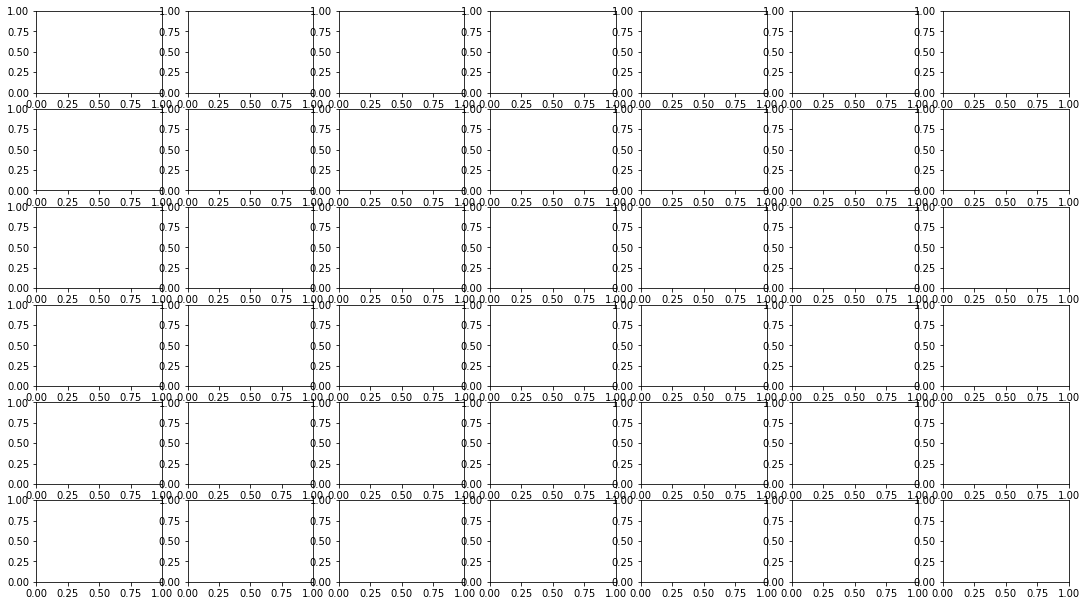

In [32]:
from pathlib import Path
subdir = "learning_rate_tuning_final_10k_epochs"
Path(subdir).mkdir(parents=True, exist_ok=True)
#test the learning rate after hyperparameter optimization
for lr in (0.000005,):
    dir_to_save = os.path.join(subdir,"lr_" + str(lr))
    Path(dir_to_save).mkdir(parents=True, exist_ok=True)
    fig, axs = plt.subplots(6,7) #6rows,7cols for 40 diagrams
    fig.set_size_inches(18.5, 10.5)
    errs = []
    
    n_p = 0
    n_n = 0
    n_fp = 0
    n_fn = 0
    n_errs = 0
    
    for id_ in range(1,41):
        print("Training On user:",id_,"with learning rate",lr)
        user_data = user_datas[id_]
        X_train,y_train,X_valid,y_valid = user_data["X_train"],user_data["y_train"], user_data["X_valid"],user_data["y_valid"]
        model, history = create_and_train_model(id_, X_train,y_train,X_valid,y_valid,learning_rate = lr)
                                                                         
        (fp,fn,p,n) = evaluate_model(id_,model,user_data["X_test"],user_data["y_test"],history,axs)
        n_errs+=fp+fn
        errs.append(fp+fn)
        
        n_p+=p
        n_n+=n
        n_fp+=fp
        n_fn+=fn
        
    print("false positive rate:",n_fp/(n_fp+n_n))
    print("false negative rate:",n_fn/(n_fn+n_p))
    print("accuracy:",1-n_errs/(40*6))
    print("F-score", (n_p) / (n_p + 0.5*(n_fp + n_fn)))
    print(n_p,n_n,n_fp,n_fn)
    plt.savefig(os.path.join(dir_to_save,"loss_" + str(lr) + ".png"))
    plt.show()
    fig = plt.hist(errs,bins=6)
    plt.savefig(os.path.join(dir_to_save,"errs_" + str(lr) + ".png"))
    

In [33]:
#run it after the previous cell
#printing statistics
print("false positive rate:",n_n/(n_fp+n_n))
print("false negative rate:",n_p/(n_fn+n_p))
print("accuracy:",1-n_errs/(40*6))
print("F-score", (n_p) / (n_p + 0.5*(n_fp + n_fn)))

ZeroDivisionError: division by zero

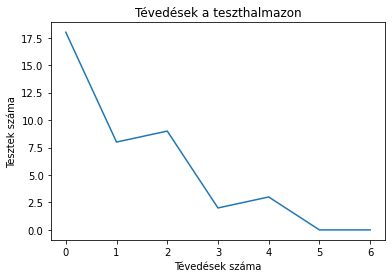

In [113]:
#plots the number of errors accross the dataset (i.e. 40 user)
y = [errs[::2].count(0),errs[::2].count(1),errs[::2].count(2),errs[::2].count(3),errs[::2].count(4),errs[::2].count(5),errs[::2].count(6)]
plt.plot([0,1,2,3,4,5,6],y)
plt.title('Tévedések a teszthalmazon')
plt.xlabel('Tévedések száma')
plt.ylabel('Tesztek száma')
plt.savefig(os.path.join(dir_to_save,"plot_errs" + str(lr) + ".png"))
plt.show()